In [7]:
from tadv.utils import load_dotenv

load_dotenv()
from workflow.s2_experiments.t1_relevant_column_detection.string_matching import run_string_matching_for_rcd
from workflow.s2_experiments.t1_relevant_column_detection.metrics import RelevantColumnDetectionMetric
from workflow.s2_experiments.utils import load_previous_and_new_spark_data

from tadv.utils import get_task_instance
from tadv.dq_manager import DeequDataQualityManager
from tadv.inspector.deequ.deequ_inspector_manager import DeequInspectorManager
from tadv.llm.langchain import LangChainCADV
from tadv.llm.langchain.downstream_task_prompt import SQL_QUERY_TASK_DESCRIPTION, \
    ML_INFERENCE_TASK_DESCRIPTION, WEB_TASK_DESCRIPTION
from tadv.utils import get_project_root

task_group_mapping = {
    'bi': 'sql_query',
    'dev': 'sql_query',
    'feature_engineering': 'sql_query',
    'classification': 'ml_inference',
    'regression': 'ml_inference',
    'info': 'webpage_generation'
}


In [8]:
def run_langchain_cadv_on_single_model(dataset_name, model_name, processed_data_label):
    dq_manager = DeequDataQualityManager()

    original_data_path = get_project_root() / "data" / f"{dataset_name}"

    spark_previous_data, spark_previous, _, _ = load_previous_and_new_spark_data(
        dataset_name=dataset_name,
        downstream_task="sql_query",
        processed_data_label=processed_data_label,
        dq_manager=dq_manager
    )

    column_list = sorted(spark_previous_data.columns, key=lambda x: x.lower())

    column_desc = DeequInspectorManager().spark_df_to_column_desc(spark_previous_data, spark_previous)

    metric_evaluator = RelevantColumnDetectionMetric(average='macro')
    result_each_type = {}
    for task_type in ['bi', 'dev', 'feature_engineering', 'classification', 'regression', 'info']:
        scripts_path_dir = original_data_path / "scripts" / task_group_mapping[task_type]
        print(task_type, end=' ')
        all_ground_truth_vectors = []
        all_relevant_columns_vectors = []
        for script_path in sorted(scripts_path_dir.iterdir(), key=lambda x: x.name):
            if task_type not in script_path.name and task_type != 'info':
                continue
            task_instance = get_task_instance(script_path)

            if model_name == "string-matching":
                relevant_columns_list = run_string_matching_for_rcd(column_list, task_instance.original_script)
            else:
                relevant_columns_list = run_llm(column_desc, model_name, task_instance.original_script,
                                                task_group_mapping[task_type])

            ground_truth = sorted(task_instance.annotations['required_columns'], key=lambda x: x.lower())
            ground_truth_vector, relevant_columns_vector = metric_evaluator.binary_vectorize(column_list,
                                                                                             ground_truth,
                                                                                             relevant_columns_list)
            all_ground_truth_vectors.append(ground_truth_vector)
            all_relevant_columns_vectors.append(relevant_columns_vector)
            print(script_path.name)
        result_each_type[task_type] = [all_ground_truth_vectors, all_relevant_columns_vectors]
    print("done")
    return result_each_type


def run_llm(column_desc, model_name, script_context, task_group):
    input_variables = {
        "column_desc": column_desc,
        "script": script_context,
    }
    if task_group == 'sql_query':
        lc = LangChainCADV(model_name=model_name, downstream_task_description=SQL_QUERY_TASK_DESCRIPTION)
    elif task_group == 'ml_inference':
        lc = LangChainCADV(model_name=model_name, downstream_task_description=ML_INFERENCE_TASK_DESCRIPTION)
    elif task_group == 'webpage_generation':
        lc = LangChainCADV(model_name=model_name, downstream_task_description=WEB_TASK_DESCRIPTION)
    else:
        raise ValueError(f"Unknown task group: {task_group}")
    max_retries = 3
    relevant_columns_list, expectations, suggestions = lc.invoke(
        input_variables=input_variables, num_stages=1, max_retries=max_retries
    )
    relevant_columns_list = sorted(relevant_columns_list, key=lambda x: x.lower())
    return relevant_columns_list


def run_langchain_cadv_on_all_models(dataset_name, model_names, processed_data_label):
    result_each_model = {}
    for model_name in model_names:
        print(model_name, end=': ')
        result_each_model[model_name] = run_langchain_cadv_on_single_model(dataset_name, model_name,
                                                                           processed_data_label)
    return result_each_model

In [9]:
dataset_name_options = ["playground-series-s4e10", "healthcare_dataset"]
# model_names = ["string-matching", "llama3.2:1b", "llama3.2", "gpt-4o-mini", "gpt-4o"]
model_names = ["string-matching", "llama3.2:1b", "llama3.2:3b", "gpt-3.5-turbo", "gpt-4o-mini", "gpt-4o",
               "gpt-4.5-preview"]
# model_names = ["string-matching"]
processed_data_label = '0'
dataset_name = dataset_name_options[1]

all_results = run_langchain_cadv_on_all_models(dataset_name=dataset_name,
                                               model_names=model_names,
                                               processed_data_label=processed_data_label)

string-matching: 

bi bi_0.sql
bi_1.sql
bi_2.sql
bi_3.sql
bi_4.sql
bi_5.sql
bi_6.sql
bi_7.sql
bi_8.sql
bi_9.sql
dev dev_0.sql
dev_1.sql
dev_2.sql
dev_3.sql
dev_4.sql
dev_5.sql
dev_6.sql
dev_7.sql
dev_8.sql
dev_9.sql
feature_engineering feature_engineering_0.sql
feature_engineering_1.sql
feature_engineering_2.sql
feature_engineering_3.sql
feature_engineering_4.sql
feature_engineering_5.sql
feature_engineering_6.sql
feature_engineering_7.sql
feature_engineering_8.sql
feature_engineering_9.sql
classification classification_0.py
classification_1.py
classification_2.py
classification_3.py
classification_4.py
classification_5.py
classification_6.py
classification_7.py
classification_8.py
classification_9.py
regression regression_0.py
regression_1.py
regression_2.py
regression_3.py
regression_4.py
info info_0.py
info_1.py
info_2.py
info_3.py
info_4.py
info_5.py
info_6.py
info_7.py
info_8.py
info_9.py
done
llama3.2:1b: bi bi_0.sql
bi_1.sql
bi_2.sql
bi_3.sql
bi_4.sql
bi_5.sql
bi_6.sql
bi_7.sql
bi_8.sql
bi_9.sql
d

bi bi_0.sql
bi_1.sql
bi_2.sql
bi_3.sql
bi_4.sql
bi_5.sql
bi_6.sql
bi_7.sql
bi_8.sql
bi_9.sql
dev dev_0.sql
dev_1.sql
dev_2.sql
dev_3.sql
dev_4.sql
dev_5.sql
dev_6.sql
dev_7.sql
dev_8.sql
dev_9.sql
feature_engineering feature_engineering_0.sql
feature_engineering_1.sql
feature_engineering_2.sql
feature_engineering_3.sql
feature_engineering_4.sql
feature_engineering_5.sql
feature_engineering_6.sql
feature_engineering_7.sql
feature_engineering_8.sql
feature_engineering_9.sql
classification classification_0.py
classification_1.py
classification_2.py
classification_3.py
classification_4.py
classification_5.py
classification_6.py
classification_7.py
classification_8.py
classification_9.py
regression regression_0.py
regression_1.py
regression_2.py
regression_3.py
regression_4.py
info info_0.py
info_1.py
info_2.py
info_3.py
info_4.py
info_5.py
info_6.py
info_7.py
info_8.py
info_9.py
done
gpt-3.5-turbo: 

bi bi_0.sql
bi_1.sql
bi_2.sql
bi_3.sql
bi_4.sql
bi_5.sql
bi_6.sql
bi_7.sql
bi_8.sql
bi_9.sql
dev dev_0.sql
dev_1.sql
dev_2.sql
dev_3.sql
dev_4.sql
dev_5.sql
dev_6.sql
dev_7.sql
dev_8.sql
dev_9.sql
feature_engineering feature_engineering_0.sql
feature_engineering_1.sql
feature_engineering_2.sql
feature_engineering_3.sql
feature_engineering_4.sql
feature_engineering_5.sql
feature_engineering_6.sql
feature_engineering_7.sql
feature_engineering_8.sql
feature_engineering_9.sql
classification classification_0.py
classification_1.py
classification_2.py
classification_3.py
classification_4.py
classification_5.py
classification_6.py
classification_7.py
classification_8.py
classification_9.py
regression regression_0.py
regression_1.py
regression_2.py
regression_3.py
regression_4.py
info info_0.py
info_1.py
info_2.py
info_3.py
info_4.py
info_5.py
info_6.py
info_7.py
info_8.py
info_9.py
done
gpt-4o-mini: 

bi bi_0.sql
bi_1.sql
bi_2.sql
bi_3.sql
bi_4.sql
bi_5.sql
bi_6.sql
bi_7.sql
bi_8.sql
bi_9.sql
dev dev_0.sql
dev_1.sql
dev_2.sql
dev_3.sql
dev_4.sql
dev_5.sql
dev_6.sql
dev_7.sql
dev_8.sql
dev_9.sql
feature_engineering feature_engineering_0.sql
feature_engineering_1.sql
feature_engineering_2.sql
feature_engineering_3.sql
feature_engineering_4.sql
feature_engineering_5.sql
feature_engineering_6.sql
feature_engineering_7.sql
feature_engineering_8.sql
feature_engineering_9.sql
classification classification_0.py
classification_1.py
classification_2.py
classification_3.py
classification_4.py
classification_5.py
classification_6.py
classification_7.py
classification_8.py
classification_9.py
regression regression_0.py
regression_1.py
regression_2.py
regression_3.py
regression_4.py
info info_0.py
info_1.py
info_2.py
info_3.py
info_4.py
info_5.py
info_6.py
info_7.py
info_8.py
info_9.py
done
gpt-4o: bi bi_0.sql
bi_1.sql
bi_2.sql
bi_3.sql
bi_4.sql
bi_5.sql
bi_6.sql
bi_7.sql
bi_8.sql
bi_9.sql
dev de

(10, 16)
(10, 16)
(10, 16)
(10, 16)
(10, 16)
(10, 16)
(10, 16)


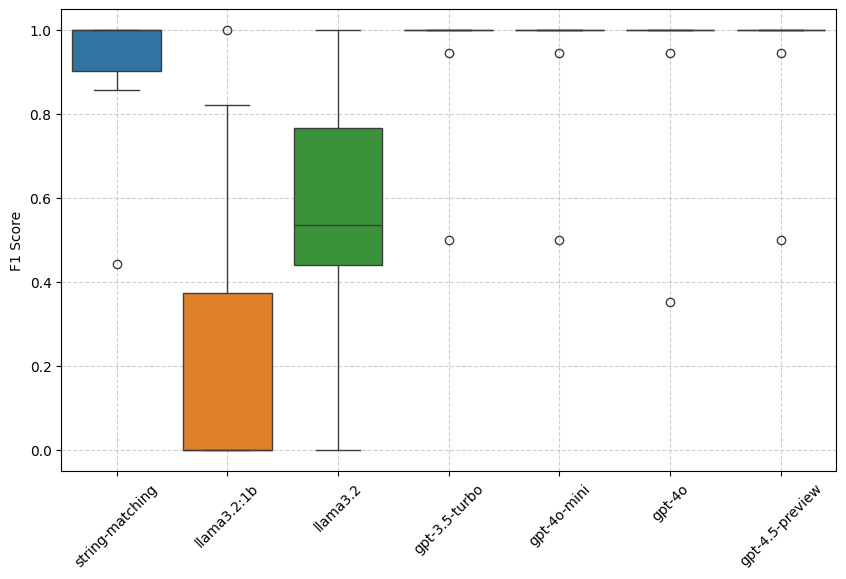

(10, 16)
(10, 16)
(10, 16)
(10, 16)
(10, 16)
(10, 16)
(10, 16)


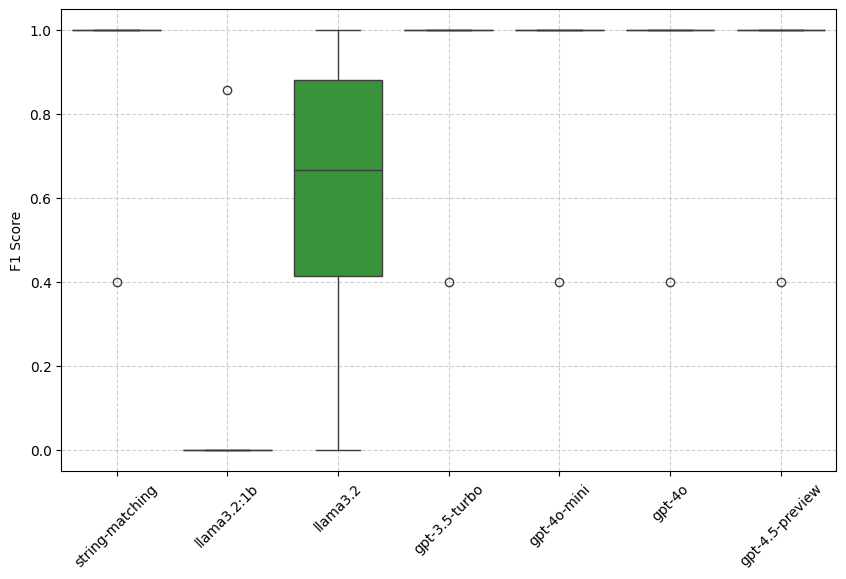

(10, 16)
(10, 16)
(10, 16)
(10, 16)
(10, 16)
(10, 16)
(10, 16)


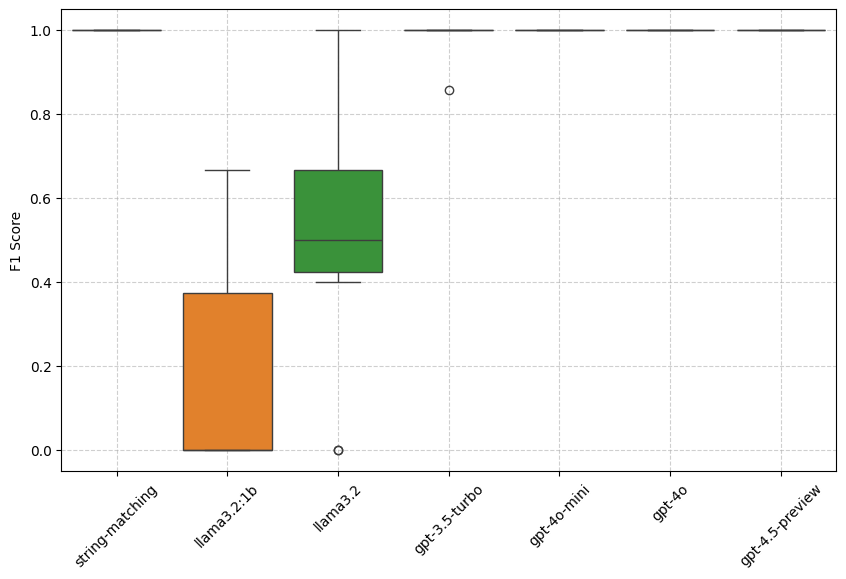

(10, 16)
(10, 16)
(10, 16)
(10, 16)
(10, 16)
(10, 16)
(10, 16)


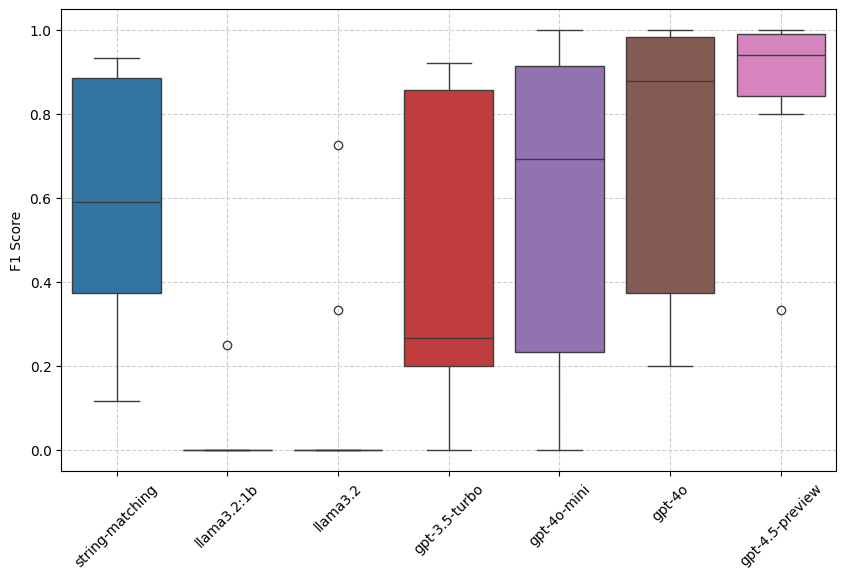

(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)
(5, 16)


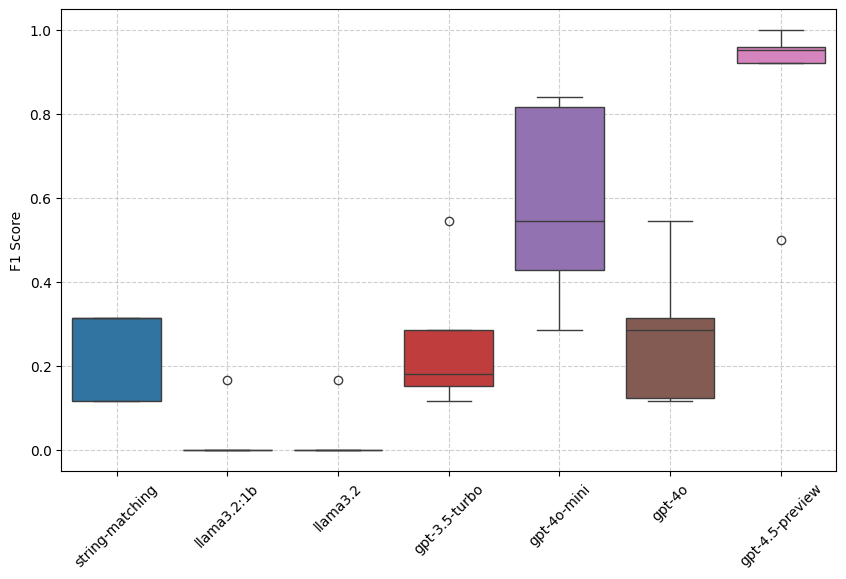

(10, 16)
(10, 16)
(10, 16)
(10, 16)
(10, 16)
(10, 16)
(10, 16)


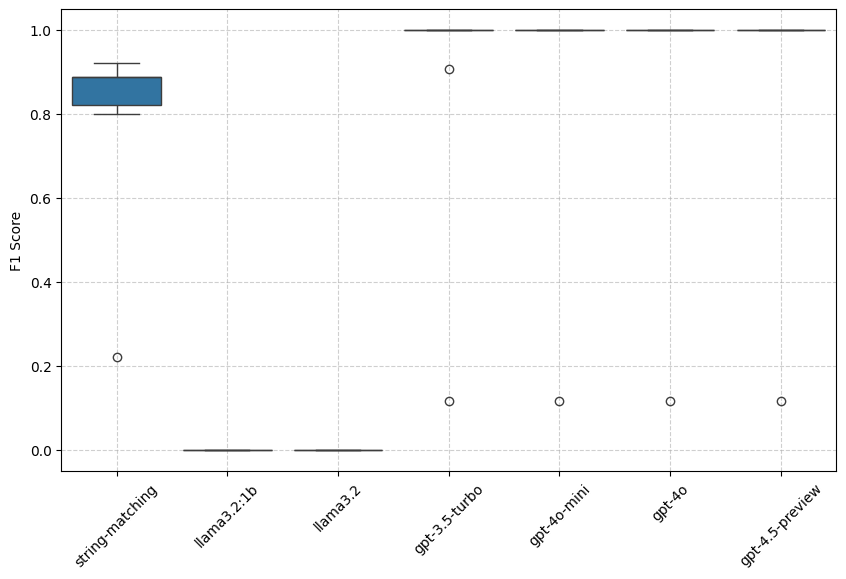

In [10]:
for task_type in list(all_results[model_names[0]].keys()):
    result_each_model = {
        model_name: all_results[model_name][task_type]
        for model_name in model_names
    }
    f1_scores_list = []
    for model_name in model_names:
        f1_scores = RelevantColumnDetectionMetric().statistics_calculation(all_results[model_name][task_type][0],
                                                                           all_results[model_name][task_type][1])
        f1_scores_list.append(f1_scores['f1_list'])
    RelevantColumnDetectionMetric().plot_f1_boxplot(f1_scores_list, model_names)


(15, 16)
(15, 16)
(15, 16)
(15, 16)
(15, 16)


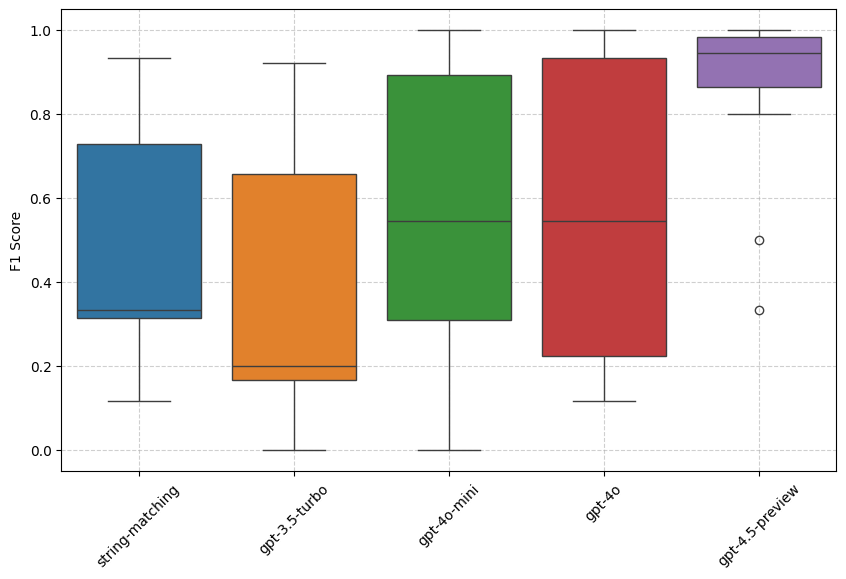

In [28]:

from matplotlib import pyplot as plt
import seaborn as sns

task_types = all_results["string-matching"].keys()
aggregated_result = {model_name: [[], []] for model_name in all_results.keys()}
f1_scores_list = []
for model_name in ["string-matching", "gpt-3.5-turbo", "gpt-4o-mini", "gpt-4o", "gpt-4.5-preview"]:
    for task in ['regression', 'classification']:
        aggregated_result[model_name][0] += all_results[model_name][task][0]
        aggregated_result[model_name][1] += all_results[model_name][task][1]
    f1_scores = RelevantColumnDetectionMetric().statistics_calculation(aggregated_result[model_name][0],
                                                                       aggregated_result[model_name][1])
    f1_scores_list.append(f1_scores['f1_list'])
plt.figure(figsize=(10, 6))
sns.boxplot(data=f1_scores_list, fill=True)
plt.xticks(ticks=range(5), labels=["string-matching", "gpt-3.5-turbo", "gpt-4o-mini", "gpt-4o", "gpt-4.5-preview"],
           rotation=45)
plt.ylabel("F1 Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
# RelevantColumnDetectionMetric().plot_f1_boxplot(f1_scores_list, model_names=)

(5, 16)
(10, 16)
(5, 16)
(10, 16)
(5, 16)
(10, 16)
(5, 16)
(10, 16)
(5, 16)
(10, 16)


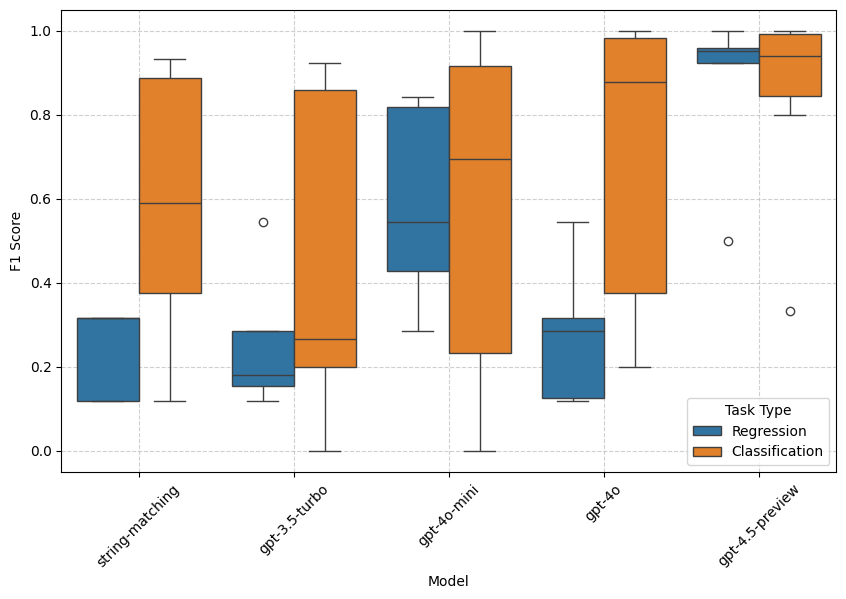

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for plotting
data = []
for model_idx, model_name in enumerate(
        ["string-matching", "gpt-3.5-turbo", "gpt-4o-mini", "gpt-4o", "gpt-4.5-preview"]):
    for task in ['regression', 'classification']:
        f1_scores = RelevantColumnDetectionMetric().statistics_calculation(
            all_results[model_name][task][0],
            all_results[model_name][task][1]
        )['f1_list']
        for score in f1_scores:
            if task == 'regression':
                data.append({'Model': model_name, 'Task': 'Regression', 'F1 Score': score})
            elif task == 'classification':
                data.append({'Model': model_name, 'Task': 'Classification', 'F1 Score': score})
            elif task == 'bi':
                data.append({'Model': model_name, 'Task': 'SQL Query', 'F1 Score': score})

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x="Model", y="F1 Score", hue="Task", data=df)

plt.xticks(rotation=45)
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Task Type")
plt.show()